In [1]:
from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# External Lib imports
import collections
import html
import os
import pickle
import re
from functools import partial
from pathlib import Path
from typing import Callable

import pandas as pd
import sklearn
from tqdm import tqdm

os.environ['QT_QPA_PLATFORM']='offscreen'

# FastAI Imports
from fastai import text, core, lm_rnn

# Torch imports
import torch.nn as nn
import torch.tensor as T
import torch.nn.functional as F

# Mytorch imports
from mytorch import loops as mtlp
from mytorch.utils.goodies import *
from mytorch import lriters as mtlr

device = torch.device('cuda')
np.random.seed(42)
torch.manual_seed(42)

# Macros

In [3]:
DEBUG = True
TRIM = True

# Path fields
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

WIKI_DATA_PATH = Path('raw/wikitext/wikitext-103/')
WIKI_DATA_PATH.mkdir(exist_ok=True)
IMDB_DATA_PATH = Path('raw/imdb/aclImdb/')
IMDB_DATA_PATH.mkdir(exist_ok=True)
PATH = Path('resources/proc/imdb')
DATA_PROC_PATH = PATH / 'data'
DATA_LM_PATH = PATH / 'datalm'

LM_PATH = Path('resources/models')
LM_PATH.mkdir(exist_ok=True)
PRE_PATH = LM_PATH / 'wt103'
PRE_LM_PATH = PRE_PATH / 'fwd_wt103.h5'
CLASSES = ['neg', 'pos', 'unsup']
WIKI_CLASSES = ['wiki.train.tokens', 'wiki.valid.tokens', 'wiki.test.tokens']

# Data Sampler

In [4]:
class DomainAgnosticSampler:
    """ Sample data for language model training from two different domains in one batch. """

    def __init__(self, data_fn, data_a, data_b):
        """
            Here, data_fn would be something like
                `partial(text.LanguageModelLoader, bs=bs, bptt=bptt)`
            And data_a/b would be something like
                `{'train': np.concatenate(trn_lm), 'valid': np.concatenate(val_lm)}['train']`
            data_fn (fastai's language model loader) flattens y and returns x of seqlen, batchsize
        """
        self.args = {'data_fn': data_fn, 'data_a': data_a, 'data_b': data_b}
        self.reset(**self.args)

    def reset(self, data_fn, data_a, data_b):
        self.itera = iter(data_fn(data_a))
        self.iterb = iter(data_fn(data_b))

    def __iter__(self):
        return self

    def __next__(self):
        x_a, y_a = self.itera.__next__()
        x_b, y_b = self.iterb.__next__()
        return self._combine_batch_(x_a, x_b, y_a, y_b)

    def __len__(self):
        return min(len(self.args['data_fn'](self.args['data_a'])),
                   len(self.args['data_fn'](self.args['data_b'])))

    @staticmethod
    def _combine_batch_(x_a, x_b, y_a, y_b):
        """
            :param x_a is a np.arr looks like seqlen, batchsize
            :param y_a is a corresponding np.arr (one word ahead than x_a) which is a flattened x_a.shape mat
             Same for x_b, y_b

             Returns x, y, y_dom in similar shapes as input
        """

        # Get them to interpretable shapes
        y_a = y_a.reshape(x_a.shape).transpose(1, 0)
        y_b = y_b.reshape(x_b.shape).transpose(1, 0)
        x_a = x_a.transpose(1, 0)
        x_b = x_b.transpose(1, 0)

        b_bs, b_sl = x_a.shape[0], min(x_a.shape[1], x_b.shape[1])

        # Concatenate to make an x and y
        x = np.concatenate((x_a[:, :b_sl], x_b[:, :b_sl]))
        y = np.concatenate((y_a[:, :b_sl], y_b[:, :b_sl]))

        # Shuffle and remember shuffle index to make y labels for domain agnostic training
        intrp = np.arange(b_bs * 2)
        np.random.shuffle(intrp)
        y_dom = (intrp >= b_bs) * 1
        x = x[intrp]
        y = y[intrp]

        x = x.transpose(1, 0)
        y = y.transpose(1, 0).reshape(np.prod(y.shape))

        return x, y, y_dom

# Data

Load **IMDB** data from disk

In [5]:
def get_texts_org(path):
    texts, labels = [], []
    for idx, label in enumerate(CLASSES):
        for fname in (path / label).glob('*.*'):
            texts.append(fname.open('r', encoding='utf-8').read())
            labels.append(idx)
    return np.array(texts), np.array(labels)

trn_texts, trn_labels = get_texts_org(IMDB_DATA_PATH / 'train')
val_texts, val_labels = get_texts_org(IMDB_DATA_PATH / 'test')
col_names = ['labels', 'text']
print(len(trn_texts), len(val_texts))

75000 25000


Load **WIKI** data from disk

In [6]:
def is_valid_sent(x):
    x = x.strip()
    if len(x) == 0: return False
    if x[0] == '=' and x[-1] == '=': return False
    return True


def wiki_get_texts_org(path):
    texts = []
    for idx, label in enumerate(WIKI_CLASSES):
        with open(path / label, encoding='utf-8') as f:
            texts.append([sent.strip() for sent in f.readlines() if is_valid_sent(sent)])
    return tuple(texts)


wiki_trn_texts, wiki_val_texts, wiki_tst_texts = wiki_get_texts_org(WIKI_DATA_PATH)
print(len(wiki_trn_texts), len(wiki_val_texts))

859955 1841


If needed, trim data to only keep top 1000 things from both datasets

In [7]:
if TRIM:
    trn_texts, val_texts = trn_texts[:1000], val_texts[:1000]
    wiki_trn_texts, wiki_val_texts, wiki_tst_texts = wiki_trn_texts[:1000], wiki_val_texts[:1000], wiki_tst_texts[:1000]

Shuffle data & Make dummy labels

In [8]:
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))

trn_texts, trn_labels = trn_texts[trn_idx], trn_labels[trn_idx]
val_texts, val_labels = val_texts[val_idx], val_labels[val_idx]

np.random.shuffle(wiki_trn_texts)
np.random.shuffle(wiki_val_texts)
np.random.shuffle(wiki_tst_texts)

wiki_trn_labels = [0 for _ in wiki_trn_texts]
wiki_val_labels = [0 for _ in wiki_val_texts]
wiki_tst_labels = [0 for _ in wiki_val_texts]

Dataframe magic & Fixing up text & Splitting into train and Val

_note_: We read generously from the valid data. Should do something about it!!

In [9]:
chunksize = 24000
re1 = re.compile(r'  +')


def _fixup_(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))


def _get_texts_(df, n_lbls=1):
    labels = df.iloc[:, range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls + 1, len(df.columns)): texts += f' {FLD} {i - n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(_fixup_).values)

    tok = text.Tokenizer().proc_all_mp(core.partition_by_cores(texts))
    return tok, list(labels)


def _simple_apply_fixup_(df):
    labels = [0] * df.shape[0]
    texts = f'\n{BOS} {FLD} 1 ' + df.text
    texts = list(texts.apply(_fixup_).values)
    tok = text.Tokenizer().proc_all_mp(core.partition_by_cores(texts))
    return tok, list(labels)


def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = _get_texts_(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

trn_texts, val_texts = sklearn.model_selection.train_test_split(
        np.concatenate([trn_texts, val_texts]), test_size=0.1)

if DEBUG:
    print(len(trn_texts), len(val_texts))

df_trn = pd.DataFrame({'text': trn_texts, 'labels': [0] * len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text': val_texts, 'labels': [0] * len(val_texts)}, columns=col_names)

trn_tok, trn_labels = _simple_apply_fixup_(df_trn)
val_tok, val_labels = _simple_apply_fixup_(df_val)

if DEBUG:
    print(f"Trn: {len(trn_tok), len(trn_labels)}, Val: {len(val_tok), len(val_labels)} ")

wiki_trn_texts, wiki_val_texts = sklearn.model_selection.train_test_split(
    np.concatenate([wiki_trn_texts, wiki_val_texts, wiki_tst_texts]), test_size=0.1)

if DEBUG:
    print(len(wiki_trn_texts), len(wiki_val_texts))

wiki_df_trn = pd.DataFrame({'text': wiki_trn_texts, 'labels': [0] * len(wiki_trn_texts)}, columns=col_names)
wiki_df_val = pd.DataFrame({'text': wiki_val_texts, 'labels': [0] * len(wiki_val_texts)}, columns=col_names)

wiki_trn_tok, wiki_trn_labels = _simple_apply_fixup_(wiki_df_trn)
wiki_val_tok, wiki_val_labels = _simple_apply_fixup_(wiki_df_val)

if DEBUG:
    print(f"Trn: {len(wiki_trn_tok), len(wiki_trn_labels)}, Val: {len(wiki_val_tok), len(wiki_val_labels)} ")

1800 200
Trn: (1800, 1800), Val: (200, 200) 
2700 300
Trn: (2700, 2700), Val: (300, 300) 


 Now we make vocabulary, select 60k most freq words 
 
 _note_: we do this looking only at imdb, and ignore wiki here

In [10]:
freq = Counter(p for o in trn_tok for p in o)
# freq.most_common(25)
max_vocab = 60000
min_freq = 2

itos = [o for o, c in freq.most_common(max_vocab) if c > min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')
stoi = collections.defaultdict(lambda: 0, {v: k for k, v in enumerate(itos)})
vs = len(itos)

trn_lm = np.array([[stoi[o] for o in p] for p in trn_tok])
val_lm = np.array([[stoi[o] for o in p] for p in val_tok])

if DEBUG:
    print(f"ITOS: {len(itos)}, STOI: {len(stoi)}")

wiki_trn_lm = np.array([[stoi[o] for o in p] for p in wiki_trn_tok])
wiki_val_lm = np.array([[stoi[o] for o in p] for p in wiki_val_tok])

if DEBUG:
    print(f"ITOS: {len(itos)}, STOI: {len(stoi)}")

ITOS: 9314, STOI: 25161
ITOS: 9314, STOI: 36993


# Model

Now we pull pretrained models from disk

In [11]:
em_sz, nh, nl = 400, 1150, 3
# PRE_PATH = PATH / 'models' / 'wt103'
# PRE_LM_PATH = PRE_PATH / 'fwd_wt103.h5'
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)
enc_wgts = core.to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)
itos2 = pickle.load((PRE_PATH / 'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda: -1, {v: k for k, v in enumerate(itos2)})
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i, w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r >= 0 else row_m

wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))
wgts_enc = {'.'.join(k.split('.')[1:]): val
            for k, val in wgts.items() if k[0] == '0'}
wgts_dec = {'.'.join(k.split('.')[1:]): val
            for k, val in wgts.items() if k[0] == '1'}

Define Model

In [12]:
class CustomEncoder(lm_rnn.RNN_Encoder):

    @property
    def layers(self):
        return torch.nn.ModuleList([torch.nn.ModuleList([self.rnns[0], self.dropouths[0]]),
                                    torch.nn.ModuleList([self.rnns[1], self.dropouths[1]]),
                                    torch.nn.ModuleList([self.rnns[2], self.dropouths[2]])])


class CustomDecoder(text.LinearDecoder):

    @property
    def layers(self):
        return torch.nn.ModuleList([self.decoder, self.dropout])

    def forward(self, input):
        raw_outputs, outputs = input
        output = self.dropout(outputs[-1])
        decoded = self.decoder(output.view(output.size(0) * output.size(1), output.size(2)))
        result = decoded.view(-1, decoded.size(1))
        return result, raw_outputs, outputs

    
class CustomLinear(lm_rnn.PoolingLinearClassifier):

    def forward(self, input):
        raw_outputs, outputs = input
        output = outputs[-1]
        sl,bs,_ = output.size()
        avgpool = self.pool(output, bs, False)
        mxpool = self.pool(output, bs, True)
        x = torch.cat([output[-1], mxpool, avgpool], 1)
        for i, l in enumerate(self.layers):
            l_x = l(x)
            if i != len(self.layers) -1:
                x = F.relu(l_x)
            else:
                x = torch.sigmoid(l_x)
        return l_x, raw_outputs, outputs


class LanguageModel(nn.Module):

    def __init__(self,
                 _parameter_dict,
                 _device,
                 _wgts_e,
                 _wgts_d,
                 _encargs):
        super(LanguageModel, self).__init__()

        self.parameter_dict = _parameter_dict
        self.device = _device

        self.encoder = CustomEncoder(**_encargs).to(self.device)
        self.encoder.load_state_dict(_wgts_e)
        """
            Explanation:
                400*3 because input is [ h_T, maxpool, meanpool ]
                0.4, 0.1 are drops at various layersLM_PATH
        """
        self.linear_dec = CustomDecoder(
            _encargs['ntoken'],
            n_hid=400,
            dropout=0.1 * 0.7,
            tie_encoder=self.encoder.encoder,
            bias=False
        ).to(self.device)

        # self.linear_dom = CustomLinear(
        #     2,
        #     n_hid=400,
        #     dropout=0.1 * 0.7,
        #     #             tie_encoder=self.encoder.encoder,
        #     bias=False
        # ).to(self.device)
        self.linear_dom = CustomLinear(layers=[400*3, 50, 2], drops=[0.2, 0.1]).to(self.device)
        self.encoder.reset()


    def forward(self, x):
        x_enc = self.encoder(x)
        return self.linear_dec(x_enc)

    def domain(self, x_enc):
        x_enc = list(x_enc)
        x_enc[1] = [GradReverse.apply(enc_tensr) for enc_tensr in x_enc[1]]
        return self.linear_dom(x_enc)[0]

    @property
    def layers(self):
        # layers = [x for x in self.encoder.layers]
        # layers.append(torch.nn.ModuleList([x for x in self.linear_dec.layers]))
        # layers.append(torch.nn.ModuleList([x for x in self.linear_dom.layers]))
        # return torch.nn.ModuleList(layers)
        return self.encoder.layers.extend(self.linear_dec.layers).extend(self.linear_dom.layers)

    def predict(self, x):
        with torch.no_grad():
            self.eval()
            pred = self.forward(x)
            self.train()
            return pred

Hyper parameters

In [13]:
wd = 1e-7
bptt = 70
bs = 16
opt_fn = partial(torch.optim.Adam, betas=(0.8, 0.99))  # @TODO: find real optimizer, and params

# Load the pre-trained model
parameter_dict = {'itos2': itos2}
dps = list(np.asarray([0.25, 0.1, 0.2, 0.02, 0.15]) * 0.7)
encargs = {'ntoken': new_w.shape[0],
           'emb_sz': 400, 'n_hid': 1150,
           'n_layers': 3, 'pad_token': 0,
           'qrnn': False, 'dropouti': dps[0],
           'wdrop': dps[2], 'dropoute': dps[3], 'dropouth': dps[4]}

# For now, lets assume our best lr = 0.001
bestlr = 0.001 * 10
lm = LanguageModel(parameter_dict, device, wgts_enc, wgts_dec, encargs)
opt = make_opt(lm, opt_fn, lr=bestlr)
loss_main_fn = F.cross_entropy
loss_aux_fn = F.cross_entropy

Make data iterators and LR iterators

In [14]:
# For now, lets assume our best lr = 0.001
bestlr = 0.001 * 10
lm = LanguageModel(parameter_dict, device, wgts_enc, wgts_dec, encargs)
opt = make_opt(lm, opt_fn, lr=bestlr)
loss_main_fn = F.cross_entropy
loss_aux_fn = F.cross_entropy

# Make data
data_fn_unidomain = partial(text.LanguageModelLoader, bs=bs, bptt=bptt)
data_imdb = {'train': np.concatenate(trn_lm), 'valid': np.concatenate(val_lm)}
data_wiki = {'train': np.concatenate(wiki_trn_lm), 'valid': np.concatenate(wiki_val_lm)}
data_fn = partial(DomainAgnosticSampler, data_fn=data_fn_unidomain)

# Set up lr and freeze stuff
for grp in opt.param_groups:
    grp['lr'] = 0.0
opt.param_groups[3]['lr'] = 1e-3 / 2
opt.param_groups[4]['lr'] = 1e-3 / 2

# lr_args = {'batches':, 'cycles': 1}
lr_args = {'iterations': len(data_fn(data_a=data_wiki['train'], data_b=data_imdb['train'])), 'cut_frac': 0.1, 'ratio': 32}
lr_schedule = mtlr.LearningRateScheduler(opt, lr_args, mtlr.SlantedTriangularLR)


# @TODO: add dom agnostic thing to eval as well?
def _eval(y_pred, y_true):
    """
        Expects a batch of input

        :param y_pred: tensor of shape (b, nc)
        :param y_true: tensor of shape (b, 1)
    """
    return torch.mean((torch.argmax(y_pred, dim=1) == y_true).float())

def _eval_dann(y_pred, y_true):
    return torch.mean((y_pred.round() == y_true).float())

Bring it all together

In [15]:
args = {'epochs': 1, 'weight_decay': 0, 'data_a': data_imdb, 'data_b': data_wiki,
        'device': device, 'opt': opt, 'loss_main_fn': loss_main_fn, 'loss_aux_fn': loss_aux_fn,
        'train_fn': lm, 'train_aux_fn': lm.domain, 'predict_fn': lm.predict, 'data_fn': data_fn, 'model': lm,
        'eval_fn': _eval, 'eval_aux_fn': _eval_dann, 'batch_start_hook': partial(mtlp.reset_hidden, lm),
        'clip_grads_at': -1.0, 'lr_schedule': lr_schedule}

# Training loop
    
        - sample from wiki
            - e(x_w)        forward from encoder
            - d(e(x_w))     forward from decoder
            - backward normally
            
            - e(x_w)'       grad reverse layer
            - d'(e(x_w)')   forward from domain agnostic layer
            - backward
            
        - sample from imdb
            - same...

In [16]:
def generic_loop(epochs: int,
                 device: torch.device,
                 opt: torch.optim,
                 loss_main_fn: torch.nn,
                 loss_aux_fn: torch.nn,
                 model: torch.nn.Module,
                 train_fn: Callable,
                 train_aux_fn: Callable,
                 predict_fn: Callable,
                 data_a: dict,
                 data_b: dict,
                 data_fn: classmethod,
                 epoch_start_hook: Callable = None,
                 epoch_end_hook: Callable = None,
                 batch_start_hook: Callable = None,
                 batch_end_hook: Callable = None,
                 weight_decay: float = 0.0,
                 clip_grads_at: float = -1.0,
                 lr_schedule=None,
                 eval_fn: Callable = None,
                 eval_aux_fn: Callable = None) -> (list, list, list):
    """

        A generic training loop, which based on diff hook fns (defined below), should handle anything given to it.

        The model need not be an nn.Module,
             but should have correctly wired forward and a predict function.

        Data should be a dict like so:
            {"train":{"x":np.arr, "y":np.arr}, "val":{"x":np.arr, "y":np.arr} }

        Train_fn must return both loss and y_pred

    :param epochs: number of epochs to train for
    :param data: data dict (structure specified above)
    :param device: torch device to init the tensors with
    :param opt: torch optimizer, with proper param_groups for better lr decay per laye
    :param loss_main_fn: torch.nn loss fn for the actual thing
    :param loss_aux_fn: torch.nn loss fn for the domain agnostic thing
    :param model: torch module (for grad clipping)
    :param train_fn: a function which takes x & y, returns loss and y_pred
    :param train_aux_fn: a function which takes x & y, returns loss and y_pred_aux
    :param predict_fn: a fn which takes x and returns y_pred
    :param epoch_start_hook: a fn that can be called @ start of every epoch (returns model, opt)
    :param epoch_end_hook: a fn that can be called @ end of every epoch (returns model, opt)
    :param batch_start_hook: a fn that can be called @ start of every batch (returns model, opt)
    :param batch_end_hook: a fn that can be called @r end of every batch (returns model, opt)
    :param weight_decay: a L2 ratio (as mentioned in (https://arxiv.org/pdf/1711.05101.pdf)
    :param clip_grads_at: in case you want gradients clipped, send the max val here
    :param lr_schedule: a schedule that is called @ every batch start.
    :param data_fn: a class to which we can pass X and Y, and get an iterator.
    :param eval_fn: function which when given pred and true, returns acc
    :param eval_aux_fn: same as eval_fn but for domain classifier's output.
    :return: traces
    """

    train_loss = []
    train_acc = []
    train_acc_aux = []
    val_acc = []
    lrs = []

    # Epoch level
    for e in range(epochs):

        per_epoch_loss = []
        per_epoch_tr_acc = []
        per_epoch_tr_acc_aux = []

        # Train
        with Timer() as timer:

            # @TODO: Add hook at start of epoch (how to decide what goes in)
            if epoch_start_hook: epoch_start_hook()

            # Make data
            trn_dl = data_fn(data_a=data_a['train'], data_b=data_b['train'])
            val_dl = data_fn(data_a=data_a['valid'], data_b=data_b['valid'])

            for x, y, y_aux in tqdm(trn_dl):

                if batch_start_hook: batch_start_hook()
                opt.zero_grad()

                if lr_schedule: lrs.append(update_lr(opt, lr_schedule.get()))

                # 0. Convert np arrs to torch tensors
                _x = torch.tensor(x, dtype=torch.long, device=device)
                _y = torch.tensor(y, dtype=torch.long, device=device)
                _y_aux = torch.tensor(y_aux, dtype=torch.long, device=device)

                # A: Normal stuff
                op = train_fn(_x)
                y_pred = op[0]
                loss = loss_main_fn(y_pred, _y)

                # Pass regular gradients
                loss.backward(retain_graph=True)

                # B: Domain agnostic stuff
                y_pred_aux = train_aux_fn(op[1:])
                loss_aux = loss_aux_fn(y_pred_aux, _y_aux)

                # Logging
                per_epoch_tr_acc.append(eval_fn(y_pred=y_pred, y_true=_y).item())
                per_epoch_tr_acc_aux.append(eval_fn(y_pred=y_pred_aux, y_true=_y_aux).item())
                per_epoch_loss.append(loss.item())

                # Pass aux gradients
                loss_aux.backward(retain_graph=False)

                # Optimizer Step
                if clip_grads_at > 0.0: torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grads_at)
                for group in opt.param_groups:
                    for param in group['params']:
                        param.data = param.data.add(-weight_decay * group['lr'], param.data)

                opt.step()
                if batch_end_hook: batch_end_hook()

            if epoch_end_hook: epoch_end_hook()

        # Val
        with torch.no_grad():

            per_epoch_vl_acc = []
            for x, y, y_aux in tqdm(val_dl):
                _x = torch.tensor(x, dtype=torch.long, device=device)
                _y = torch.tensor(y, dtype=torch.long, device=device)

                y_pred = predict_fn(_x)[0]

                per_epoch_vl_acc.append(eval_fn(y_pred, _y).item())

        # Bookkeep
        train_acc.append(np.mean(per_epoch_tr_acc))
        train_acc_aux.append(np.mean(per_epoch_tr_acc_aux))
        train_loss.append(np.mean(per_epoch_loss))
        val_acc.append(np.mean(per_epoch_vl_acc))

        print("Epoch: %(epo)03d | Loss: %(loss).5f | Tr_c: %(tracc)0.5f | Tr_aux: %(tracc_aux)0.5f | "
              "Vl_c: %(vlacc)0.5f | Time: %(time).3f min"
              % {'epo': e,
                 'loss': float(np.mean(per_epoch_loss)),
                 'tracc': float(np.mean(per_epoch_tr_acc)),
                 'tracc_aux': float(np.mean(per_epoch_tr_acc_aux)),
                 'vlacc': float(np.mean(per_epoch_vl_acc)),
                 'time': timer.interval / 60.0})

    return train_acc, train_acc_aux, train_loss, val_acc, lrs

# Training

In [17]:
traces_start = generic_loop(**args)

# Now unfreeze all layers and apply discr
for grp in opt.param_groups:
    grp['lr'] = bestlr

lr_dscr = lambda opt, lr, fctr=2.6: [lr / (fctr ** i) for i in range(len(opt.param_groups))[::-1]]
update_lr(opt, lr_dscr(opt, bestlr))

if DEBUG:
    print([x['lr'] for x in opt.param_groups])

lr_args = {'iterations': len(data_fn(data_a=data_wiki['train'], data_b=data_imdb['train']))*15, 'cut_frac': 0.1, 'ratio': 32}
lr_schedule = mtlr.LearningRateScheduler(opt, lr_args, mtlr.SlantedTriangularLR)
args['lr_schedule'] = lr_schedule
args['epochs'] = 15

traces_main = generic_loop(**args)
traces = [a+b for a, b in zip(traces_start, traces_main)]

100%|██████████| 29/29 [00:00<00:00, 42.56it/s]

Epoch: 000 | Loss: 4.89826 | Tr_c: 0.21558 | Tr_aux: 0.45590 | Vl_c: 0.22641 | Time: 0.484 min


[3.237128297390677e-05,
 8.416533573215762e-05,
 0.00021882987290360977,
 0.0005689576695493855,
 0.0014792899408284023,
 0.003846153846153846,
 0.01]

  0%|          | 1/287 [00:00<00:40,  7.14it/s]

[3.237128297390677e-05, 8.416533573215762e-05, 0.00021882987290360977, 0.0005689576695493855, 0.0014792899408284023, 0.003846153846153846, 0.01]


  0%|          | 1/287 [00:00<00:40,  7.13it/s]

Epoch: 000 | Loss: 4.59243 | Tr_c: 0.23550 | Tr_aux: 0.94774 | Vl_c: 0.25879 | Time: 0.483 min


  0%|          | 1/287 [00:00<00:40,  7.11it/s]

Epoch: 001 | Loss: 4.29103 | Tr_c: 0.25569 | Tr_aux: 0.90396 | Vl_c: 0.26637 | Time: 0.484 min


  0%|          | 1/287 [00:00<00:41,  6.95it/s]

Epoch: 002 | Loss: 4.25157 | Tr_c: 0.25860 | Tr_aux: 0.78571 | Vl_c: 0.27267 | Time: 0.489 min


  0%|          | 1/287 [00:00<00:40,  7.07it/s]

Epoch: 003 | Loss: 4.21146 | Tr_c: 0.26246 | Tr_aux: 0.75490 | Vl_c: 0.27403 | Time: 0.490 min


  0%|          | 1/287 [00:00<00:40,  7.06it/s]

Epoch: 004 | Loss: 4.18219 | Tr_c: 0.26550 | Tr_aux: 0.73421 | Vl_c: 0.27446 | Time: 0.491 min


  0%|          | 1/287 [00:00<00:40,  7.06it/s]

Epoch: 005 | Loss: 4.15557 | Tr_c: 0.26643 | Tr_aux: 0.71625 | Vl_c: 0.27546 | Time: 0.502 min


  0%|          | 1/287 [00:00<00:40,  7.09it/s]

Epoch: 006 | Loss: 4.13121 | Tr_c: 0.26877 | Tr_aux: 0.70884 | Vl_c: 0.27979 | Time: 0.494 min


  0%|          | 1/287 [00:00<00:40,  7.02it/s]

Epoch: 007 | Loss: 4.11381 | Tr_c: 0.27055 | Tr_aux: 0.69980 | Vl_c: 0.27672 | Time: 0.496 min


  0%|          | 1/287 [00:00<00:40,  7.03it/s]

Epoch: 008 | Loss: 4.09879 | Tr_c: 0.27211 | Tr_aux: 0.70819 | Vl_c: 0.28219 | Time: 0.499 min


  0%|          | 1/287 [00:00<00:42,  6.78it/s]

Epoch: 009 | Loss: 4.08807 | Tr_c: 0.27274 | Tr_aux: 0.70536 | Vl_c: 0.28274 | Time: 0.492 min


  0%|          | 1/287 [00:00<00:40,  7.14it/s]

Epoch: 010 | Loss: 4.08046 | Tr_c: 0.27342 | Tr_aux: 0.69752 | Vl_c: 0.28086 | Time: 0.492 min


  0%|          | 1/287 [00:00<00:40,  7.07it/s]

Epoch: 011 | Loss: 4.07065 | Tr_c: 0.27422 | Tr_aux: 0.70449 | Vl_c: 0.28099 | Time: 0.494 min


  0%|          | 1/287 [00:00<00:40,  7.10it/s]

Epoch: 012 | Loss: 4.07142 | Tr_c: 0.27467 | Tr_aux: 0.70057 | Vl_c: 0.28110 | Time: 0.494 min


  0%|          | 1/287 [00:00<00:41,  6.93it/s]

Epoch: 013 | Loss: 4.06179 | Tr_c: 0.27535 | Tr_aux: 0.69839 | Vl_c: 0.28214 | Time: 0.485 min


100%|██████████| 29/29 [00:00<00:00, 41.00it/s]

Epoch: 014 | Loss: 4.06229 | Tr_c: 0.27568 | Tr_aux: 0.70743 | Vl_c: 0.28214 | Time: 0.496 min


# Plotting

In [31]:
from matplotlib import pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)

def plot_accs(tra, vla, axa):
    
    fig = plt.figure()
#     ax = fig.add_axes((0.1, 0.2, 0.8, 0.7))
#     ax.spines['right'].set_color('none')
#     ax.spines['top'].set_color('none')
#     plt.xticks([])
#     plt.yticks([])
    plt.plot(tra, label=f"Train Acc", linewidth=3)
    plt.plot(vla, label=f"Valid Acc", linewidth=3)
    plt.plot(axa, label=f"DAdNN Acc", linewidth=3)
    plt.show()

Populating the interactive namespace from numpy and matplotlib


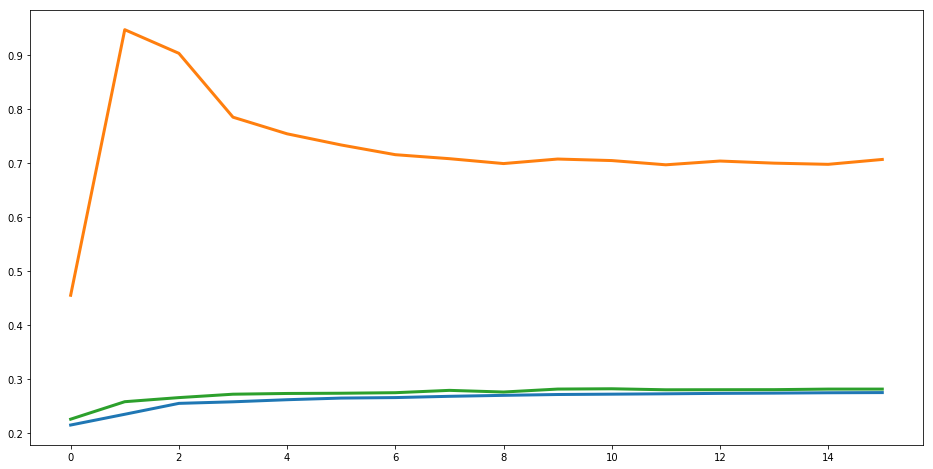

In [32]:
plot_accs(traces[0], traces[1], traces[3])

# Dumping

In [33]:
DUMPPATH = PATH / 'trim_default'

In [ ]:
# Dumping the traces
with open(DUMPPATH/'unsup_dann_traces.pkl', 'wb+') as fl:
    pickle.dump(traces, fl)

# The vocab and the models
pickle.dump(itos, open(DUMPPATH / 'itos_dann.pkl', 'wb'))
torch.save(lm.state_dict(), DUMPPATH / 'unsup_dann_model.torch')
torch.save(lm.encoder.state_dict(), DUMPPATH / 'unsup_dann_model_enc.torch')